In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,accuracy_score

import pickle

### Loading Dataset

In [ ]:
import psycopg2

conn = psycopg2.connect(database="body-performance",
                        host="localhost",
                        user="admin",
                        password="admin",
                        port="5432")

# Creazione del cursore per eseguire le query
cur = conn.cursor()

# Esecuzione della query per estrarre tutte le tabelle e colonne del database
cur.execute("SELECT * FROM body_performance")

# Estrazione dei risultati della query
results = cur.fetchall()

# Chiusura del cursore e della connessione al database
cur.close()
conn.close()

# Scrittura dei risultati in un file CSV
with open('bodyPerformance.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Table Name', 'Column Name'])
    for row in results:
        writer.writerow(row)

In [2]:
df = pd.read_csv('bodyPerformance.csv')

### Exploratory data analysis

In [3]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [4]:
df.shape

(13393, 12)

In [5]:
df.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [7]:
df.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

In [8]:
#Rename columns
df = df.rename(columns={"body fat_%":"body_fat", "height_cm":"height", "weight_kg":"weight", "sit and bend forward_cm":"bend_forward", "gripForce":"grip_force","sit-ups counts":"sit_ups", "broad jump_cm":"broad_jump"})
df.sample(10)

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump,class
8254,40.0,F,165.4,64.6,30.9,55.0,105.0,29.4,11.0,24.0,154.0,C
2619,38.0,M,169.0,74.8,19.2,85.0,129.0,31.7,9.1,35.0,204.0,C
12526,21.0,M,172.1,66.2,14.8,66.0,123.0,43.1,28.2,56.0,283.0,A
12834,31.0,M,167.4,65.0,11.7,67.0,126.0,34.6,17.3,63.0,236.0,B
7121,30.0,M,174.4,68.6,12.3,88.0,145.0,45.5,18.6,56.0,234.0,A
6790,28.0,F,162.1,52.9,22.7,75.0,130.0,31.4,25.5,41.0,160.0,A
7237,29.0,M,162.2,73.2,20.0,94.0,154.0,50.8,14.5,36.0,210.0,D
8825,22.0,F,168.3,56.3,20.9,74.0,117.0,27.4,21.5,56.0,192.0,A
3685,42.0,F,167.9,67.0,23.3,75.0,127.0,36.4,18.8,31.0,178.0,A
11359,59.0,F,163.6,62.8,32.5,80.0,121.0,25.3,26.4,37.0,176.0,A


<AxesSubplot: xlabel='class', ylabel='Count'>

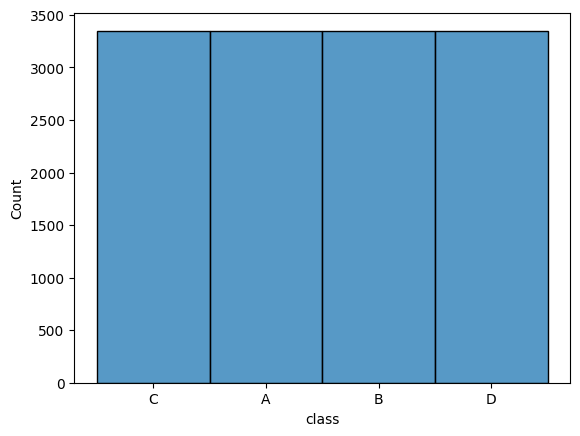

In [9]:
sns.histplot(x='class',data=df)

<AxesSubplot: xlabel='gender', ylabel='Count'>

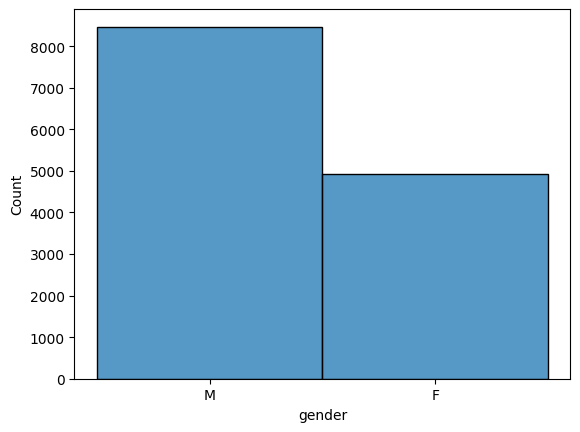

In [10]:
sns.histplot(x='gender',data = df)

<AxesSubplot: xlabel='age', ylabel='Count'>

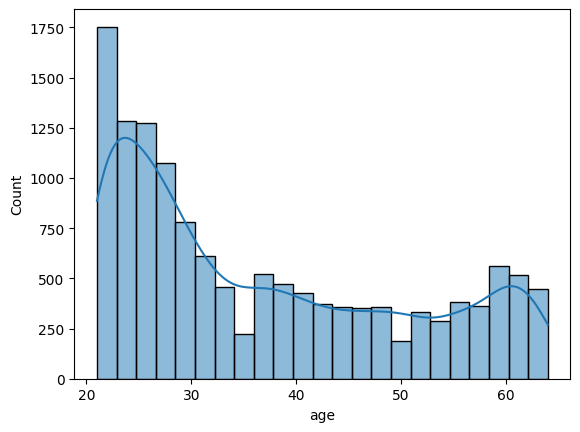

In [11]:
sns.histplot(x = 'age',data = df, kde=True)

<AxesSubplot: xlabel='height', ylabel='Count'>

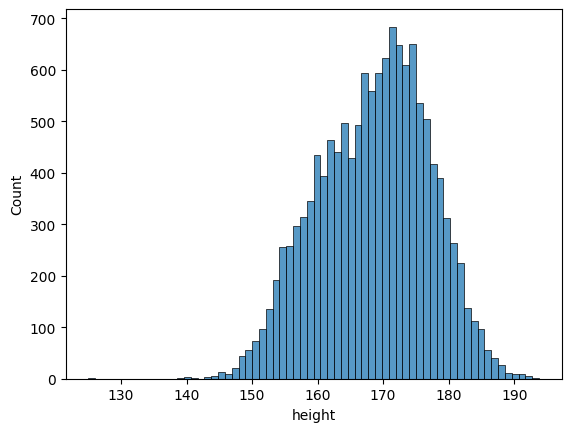

In [12]:
sns.histplot(x = 'height',data = df)

<AxesSubplot: xlabel='weight', ylabel='Count'>

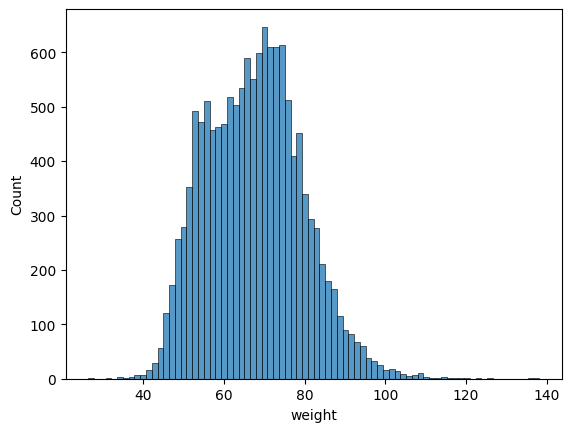

In [13]:
sns.histplot(x = 'weight',data = df)

In [14]:
df.groupby("gender").mean()

,age,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump
gender,,,,,,,,,,
F,37.850995,160.485404,56.905899,28.486085,75.578197,123.986399,25.817994,18.839791,30.888348,153.326025
M,36.149167,173.257399,73.580187,20.188151,80.669411,133.870072,43.448420,13.097073,44.939176,211.541526


<AxesSubplot: xlabel='gender', ylabel='weight'>

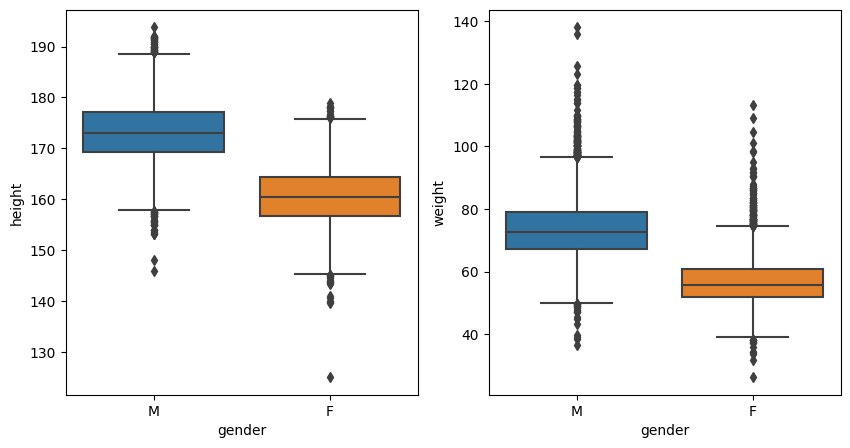

In [15]:
#Gender and height / weight
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.boxplot(x="gender", y="height", data=df, ax=ax)
ax = plt.subplot(1,2,2)
sns.boxplot(x="gender", y="weight", data=df, ax=ax)

<AxesSubplot: xlabel='gender', ylabel='body_fat'>

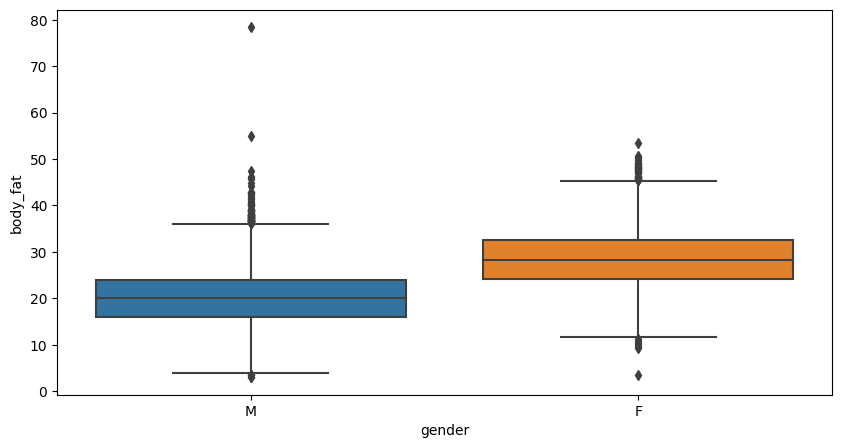

In [16]:
#Gender and body fat
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
sns.boxplot(x="gender", y="body_fat", data=df, ax=ax)

<AxesSubplot: xlabel='gender', ylabel='grip_force'>

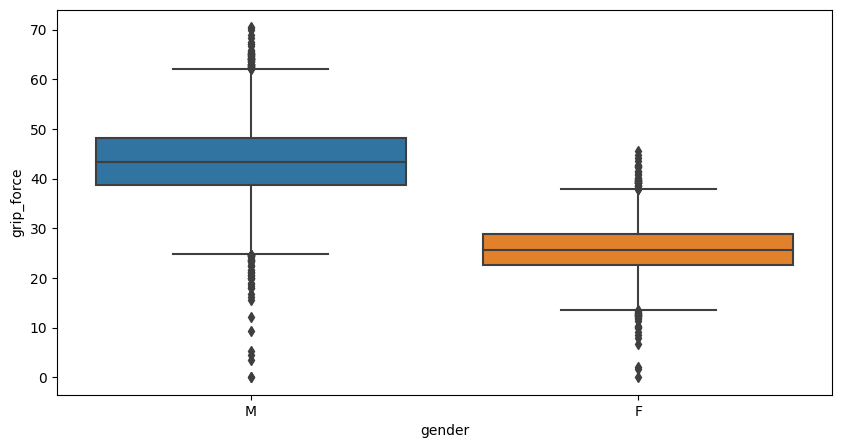

In [17]:
#Gender and gripforce
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
sns.boxplot(x="gender", y="grip_force", data=df, ax=ax)

<AxesSubplot: xlabel='class', ylabel='age'>

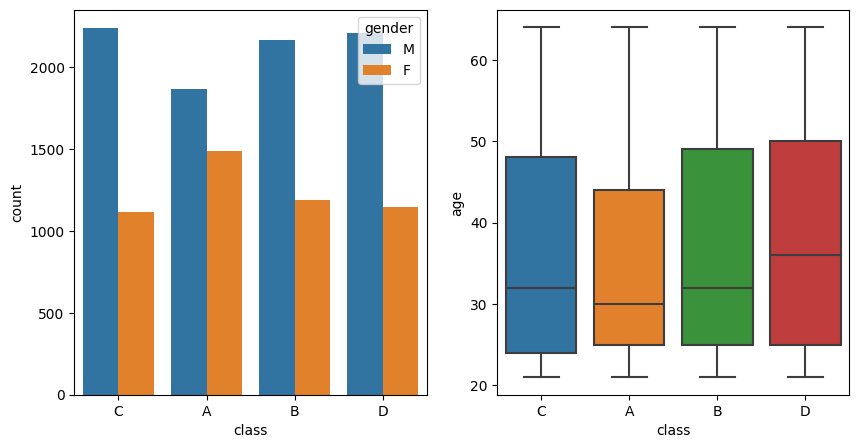

In [18]:
#Class and gender
#Class and age
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.countplot(x="class", hue="gender", data=df, ax=ax)
ax = plt.subplot(1,2,2)
sns.boxplot(x="class", y="age", data=df, ax=ax)

In [19]:
df.groupby("class")["body_fat"].mean()

class
A    20.539159
B    22.039981
C    22.644564
D    27.735432
Name: body_fat, dtype: float64

In [20]:
df.groupby("class")["sit_ups", "bend_forward", "broad_jump"].mean()

/tmp/ipykernel_192/1185934946.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("class")["sit_ups", "bend_forward", "broad_jump"].mean()


,sit_ups,bend_forward,broad_jump
class,,,
A,47.848268,21.391777,202.744026
B,42.639199,17.467586,195.332566
C,38.720215,14.390645,188.627949
D,29.881338,7.590260,173.820842


<AxesSubplot: >

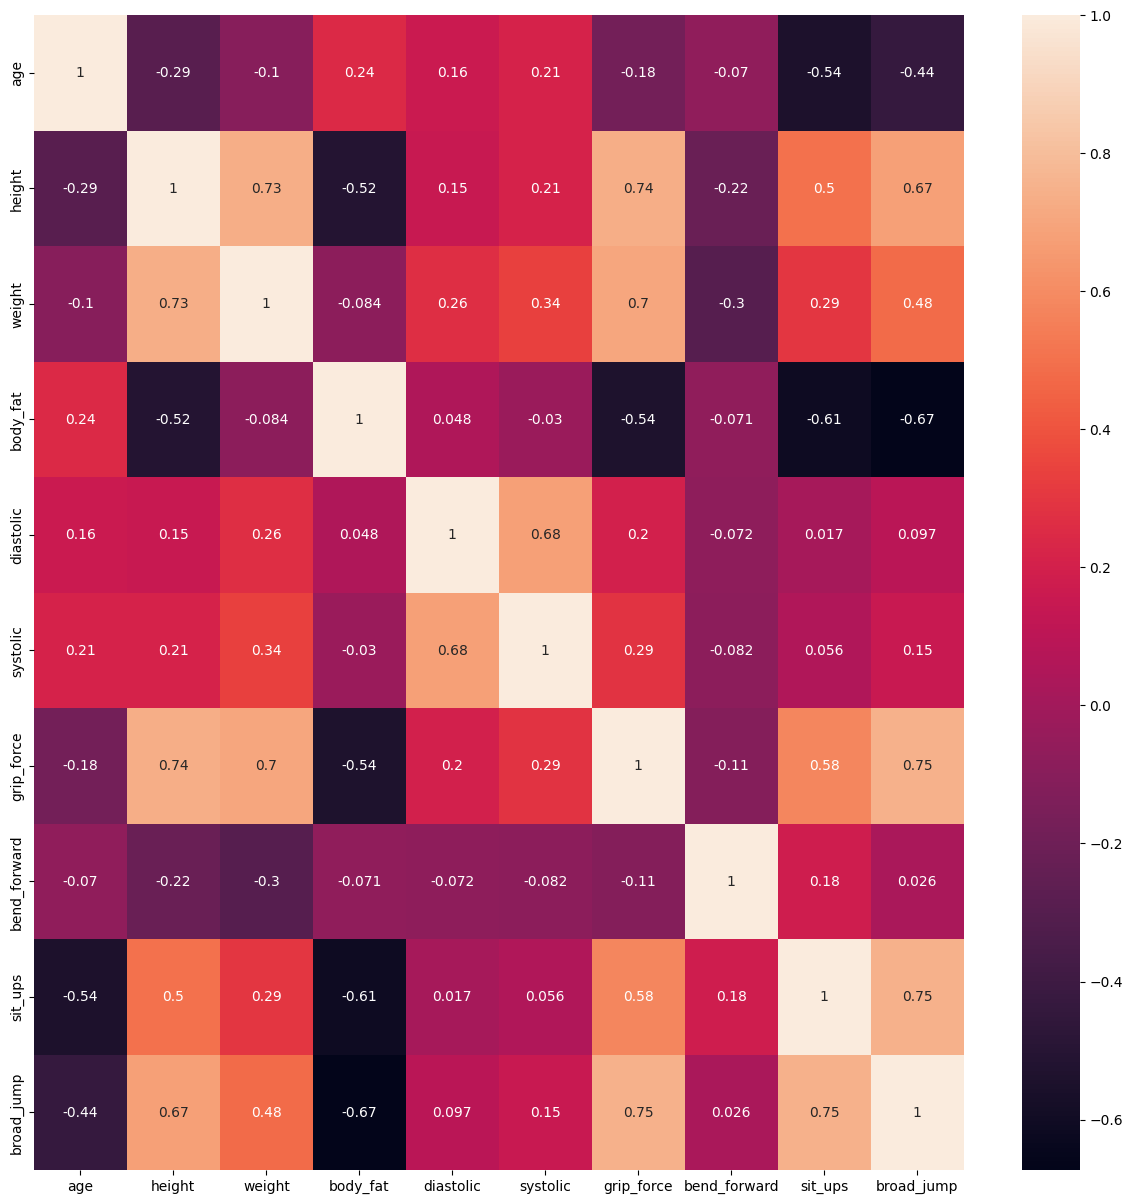

In [21]:
#correlation check
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot = True)

/tmp/ipykernel_192/4109794370.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


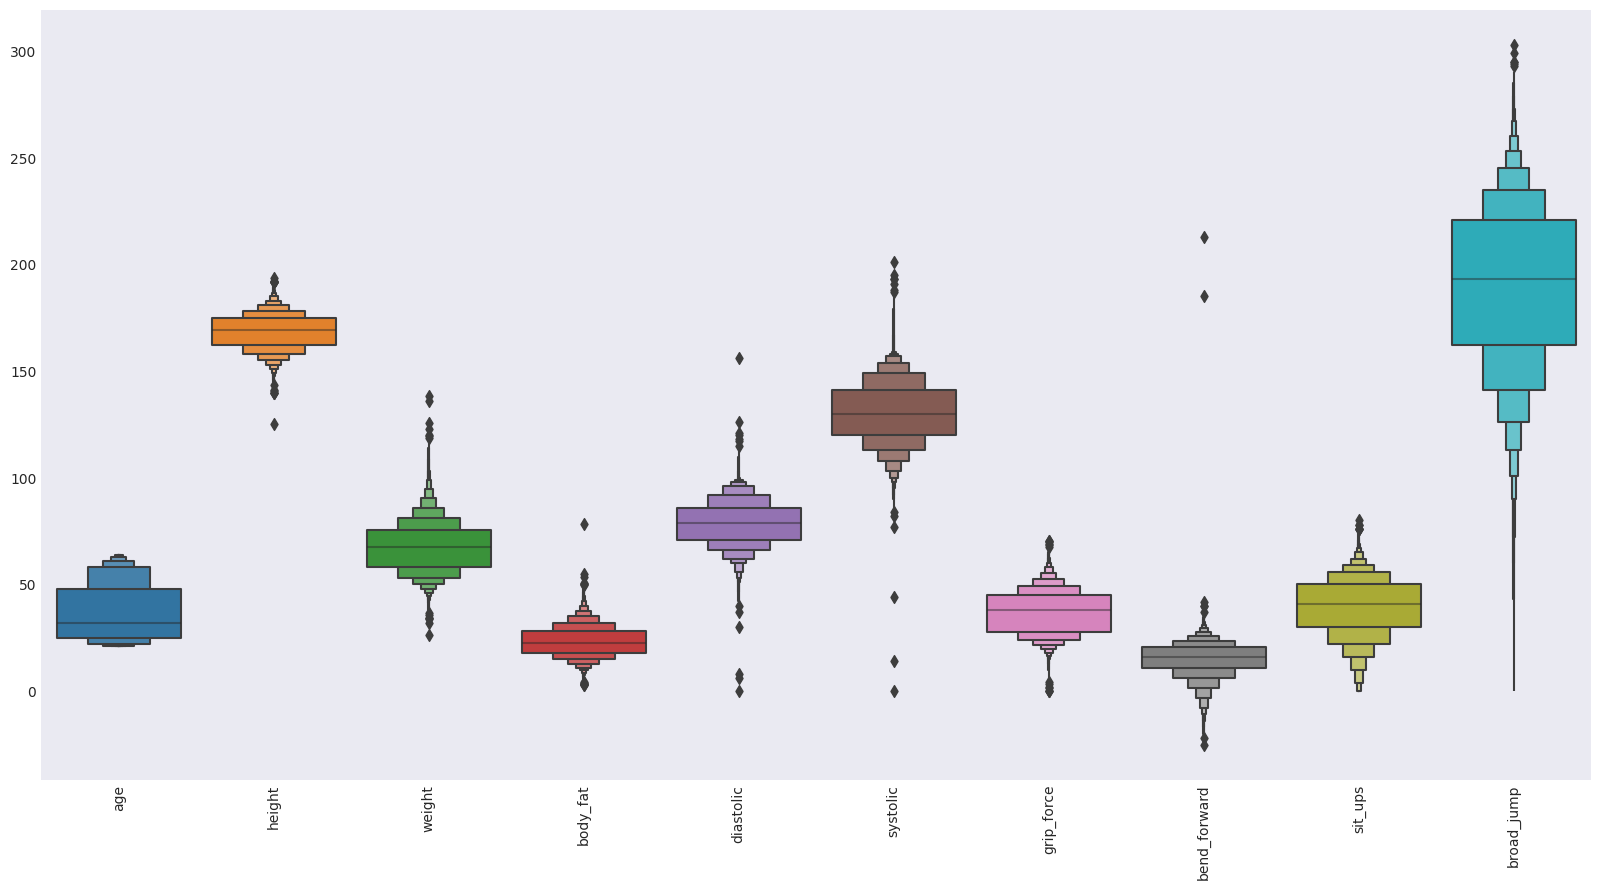

In [22]:
#Search for Outliers
plt.close()
plt.figure(figsize=(20,10))
plt.style.use('seaborn-dark')
sns.boxenplot(data = df )
plt.xticks(rotation=90)
plt.show()


### Feature engineering

In [23]:
#one hot encode of gender variable
sex = df[['gender']]
oneHot = OneHotEncoder(sparse=False)
sex = pd.DataFrame(oneHot.fit_transform(sex), columns=oneHot.get_feature_names())
df.drop(columns=['gender'], axis=1, inplace=True)
df = pd.concat([sex, df], axis=1)


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
df = df.rename(columns={'x0_F': 'F'})
df = df.rename(columns={'x0_M': 'M'})

In [25]:
#Label conversion
classes = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df['class'] = df['class'].replace(classes)

In [26]:
#conversion in meters
df['height_m'] = df.height/100

In [27]:
#creation of a new feature
df['BMI'] = df.weight /df.height_m**2
df.drop('height',axis = 1,inplace = True)
df.drop('height_m',axis = 1,inplace = True)
df.drop('weight',axis = 1,inplace = True)

In [28]:
#Label
y = df[['class']]
x = df.drop(['class'],axis = 1)
x.head()

,F,M,age,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump,BMI
0,0.0,1.0,27.0,21.3,80.0,130.0,54.9,18.4,60.0,217.0,25.344179
1,0.0,1.0,25.0,15.7,77.0,126.0,36.4,16.3,53.0,229.0,20.495868
2,0.0,1.0,31.0,20.1,92.0,152.0,44.8,12.0,49.0,181.0,24.181428
3,0.0,1.0,32.0,18.4,76.0,147.0,41.4,15.2,53.0,219.0,23.349562
4,0.0,1.0,28.0,17.1,70.0,127.0,43.5,27.1,45.0,217.0,22.412439


### Standardization

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.02,random_state = 5)

In [29]:
#Standardization
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

### Training

In [31]:
classifier = XGBClassifier()
classifier.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [32]:
#Model selection
#param_grid = {
#    'max_depth': [3, 4, 5],
#    'learning_rate': [0.1, 0.01, 0.001],
#    'n_estimators': [50, 100, 200]
#}

# Definizione della strategia di cross-validation
#cv = 5

# Definizione del GridSearchCV
#grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit del GridSearchCV sul dataset
#grid_search.fit(x_train,y_train)

#print("Best parameter:", grid_search.best_params_)
#print("Best score:", grid_search.best_score_)

### Test 

In [33]:
predict = classifier.predict(x_test)

<AxesSubplot: >

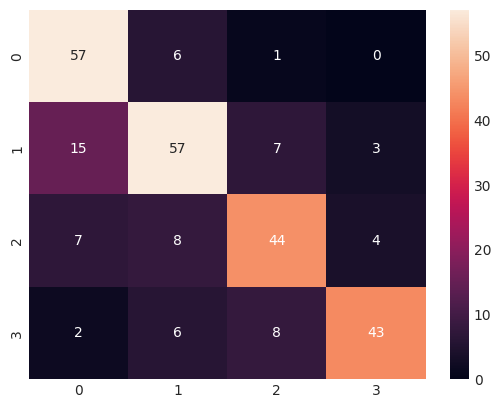

In [34]:
sns.heatmap(confusion_matrix(y_test,predict),annot=True)

In [35]:
accuracy_score(y_test,predict)

0.75

### Training on the entire dataset

In [36]:
classifier.fit(x,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Model export

In [38]:
with open('model.pickle', 'wb') as file:
    pickle.dump(classifier, file)
with open('scaler.pickle','wb') as file:
    pickle.dump(sc, file)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b233aea-2742-47eb-a00a-56daf86d858d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>